# Cox Integration

## README
This is a working example of a simplified workflow to execute Privacy Meter's membership inference attack (MIA) against Cox Regression model.

Simply execute all the code blocks one by one to get all results in sub-directory "test_cox". The results include models, model metadatas, memberships, attacks, and auditing result graphs.

### TODO

Replace the current function 'get_cox_model_signals' with another calculation method based on Cox model's available output per sample.

Currently, 'get_cox_model_signals' computes signals of the Cox models by using partial_likelihood (model.predict_partial_hazard(data)). But it's just a placeholder and is not explainable from theory.

The input of 'get_cox_model_signals' should be 'auditing dataset' and 'model list' (models). It can use any information/data the model OUTPUTs - just like a honest-but-curioius data scientist with access to internal prediction API. But it shouldn't use any model internal information, e.g. model parameters or structures.

The output of 'get_cox_model_signals' is 'signals', which stands for the computed signal values for all data records in auditing dataset for each model. The format should be the same as the current output, variable 'signals'.

The aim is to find a variable as signal. The variable should be sample-specific (each prediction should have one result), and should be explainable in theory why it differs for members and non-members (statistically or other ways).

### Possible useful materials and documentations

- Documentations:

https://lifelines.readthedocs.io/en/latest/Survival%20Regression.html#model-probability-calibration

https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Cox%20residuals.html#Deviance-residuals

https://lifelines.readthedocs.io/en/latest/fitters/regression/CoxPHFitter.html

- Papers:

Enhanced Membership Inference Attacks against Machine Learning Models. The 'Attack P(opulation)' we used in this juupyter notebook.
https://arxiv.org/pdf/2111.09679

Low-Cost High-Power Membership Inference Attacks. Better attack 'RMIA' with 'softmax' calculation
https://openreview.net/pdf?id=sT7UJh5CTc


In [1]:
import time
import pickle
import json
from lifelines import CoxPHFitter
import copy
import os
import torch

## model auditing
from pathlib import Path
import numpy as np
import torch.utils.data
from sklearn.metrics import roc_curve, auc
from torch.utils.data import Subset
from attacks import tune_offline_a, run_rmia, run_loss
from visualize import plot_roc, plot_roc_log

## build model and dataset
import pandas as pd
from lifelines.datasets import load_rossi
import matplotlib.pyplot as plt


## split dataset for training

In [2]:
def split_dataframe_for_training(dataframe, num_model_pairs):
    """
    Split a Pandas DataFrame into training and test partitions for model pairs.

    Args:
        dataframe (pd.DataFrame): Input dataset as a Pandas DataFrame.
        num_model_pairs (int): Number of model pairs to be trained, with each pair trained on different halves of the dataset.

    Returns:
        data_splits (list): List of dictionaries containing training and test DataFrames for each model.
        master_keep (np.array): Boolean array indicating the membership of samples in each model's training set.
    """
    dataset_size = len(dataframe)
    indices = np.arange(dataset_size)
    split_index = dataset_size // 2
    master_keep = np.full((2 * num_model_pairs, dataset_size), True, dtype=bool)
    data_splits = []

    for i in range(num_model_pairs):
        # Shuffle indices to randomize the dataset
        np.random.shuffle(indices)
        
        # Update master_keep for training and testing sets
        master_keep[i * 2, indices[split_index:]] = False
        master_keep[i * 2 + 1, indices[:split_index]] = False
        
        # Generate train and test indices
        train_indices_1 = np.where(master_keep[i * 2, :])[0]
        test_indices_1 = np.where(~master_keep[i * 2, :])[0]

        train_indices_2 = np.where(master_keep[i * 2 + 1, :])[0]
        test_indices_2 = np.where(~master_keep[i * 2 + 1, :])[0]
        
        # Append training and testing DataFrames for both models in the pair
        data_splits.append(
            {
                "train": dataframe.iloc[train_indices_1],
                "test": dataframe.iloc[test_indices_1],
            }
        )
        data_splits.append(
            {
                "train": dataframe.iloc[train_indices_2],
                "test": dataframe.iloc[test_indices_2],
            }
        )

    return data_splits, master_keep

## train cox models using the splitted dataset

In [3]:
def train_cox_models(data_splits, num_model_pairs, log_dir):
    """
    Train Cox proportional hazards models using data splits and store metadata.

    Args:
        data_splits (list): List of dictionaries containing "train" and "test" DataFrames.
        num_model_pairs (int): Number of model pairs to train.
        log_dir (str): Directory to store models and metadata.
        logger (logging.Logger): Logger for logging information.
        dataset_name (str): Name of the dataset used for training.

    Returns:
        list: List of trained CoxPHFitter models.
    """
    os.makedirs(log_dir, exist_ok=True)  # Ensure log directory exists
    model_list = []
    model_metadata_dict = {}

    for split_idx, split_info in enumerate(data_splits):
        #logger.info(f"Training model {split_idx}...")

        # Extract train and test sets
        train_data = split_info["train"]
        test_data = split_info["test"]

        # Initialize the CoxPH model
        model = CoxPHFitter()
        baseline_time = time.time()

        # Train the Cox model
        model.fit(train_data, duration_col="week", event_col="arrest")

        # Evaluate the model
        train_score = model.score(train_data, scoring_method="concordance_index")
        test_score = model.score(test_data, scoring_method="concordance_index")

        #train_loss = model.log_likelihood_ratio_
        #test_loss = model.compute_residuals(test_data, "martingale").abs().mean()

       # logger.info(
       #     "Training model %s took %.2f seconds", split_idx, time.time() - baseline_time
       # )

        # Store the trained model
        model_list.append(copy.deepcopy(model))

        model_idx = split_idx

        with open(f"{log_dir}/model_{model_idx}.pkl", "wb") as f:
            pickle.dump(model, f)

        # Store metadata
        model_metadata_dict[model_idx] = {
            "model_name": "CoxPHFitter",
            "num_train": len(train_data),
            "num_test": len(test_data),
            "train_acc": train_score,
            "test_acc": test_score,
            #"train_loss": train_loss,
            #"test_loss": test_loss,
            #"dataset": dataset_name,
            "model_path": f"{log_dir}/cox_model_{model_idx}.pkl",
        }

    # Save all metadata as a JSON file
    with open(f"{log_dir}/cox_models_metadata.json", "w") as f:
        json.dump(model_metadata_dict, f, indent=4)

    return model_list, model_metadata_dict


## prepare auditing dataset and memberships

In [4]:
# if no downsamples specified, use original dataset and memberships

def sample_cox_auditing_dataset(dataset, memberships):
    return dataset, memberships
#auditing_dataset = dataset
#auditing_membership = memberships

## compute pseudo ground truth - NOT USED

In [5]:
# based on median survival prediction
def define_cox_pseudo_ground_truth(data):
    pseudo_ground_truth = []
    for i in range(len(data)):
        if data['arrest'][i] == 1:
            pseudo_ground_truth.append(data['week'][i])
        else:
            pseudo_ground_truth.append(float('inf'))
    return torch.tensor(pseudo_ground_truth, dtype=torch.float64)

## compute model signals
- Use "partial likelihood per sample" to generate pseudo "loss" values. use get_loss function to compute signals and do attacks.

- Function: 

def cox_partial_likelihood_per_sample(predicted_risks, true_events, true_times)

- Explaination:

  """
  Calculates the Cox partial likelihood loss for each sample.

  Args:
      predicted_risks (torch.Tensor): Predicted risks from the Cox model.
  
      true_events (torch.Tensor): Indicator vector for events (1 for event, 0 for censored).
  
      true_times (torch.Tensor): Survival times for each sample.

  Returns:
      torch.Tensor: A tensor containing the loss for each sample.
  """

In [6]:
def cox_partial_likelihood_per_sample(predicted_risks, true_events, true_times):
  """
  Calculates the Cox partial likelihood loss for each sample.

  Args:
      predicted_risks (torch.Tensor): Predicted risks from the Cox model.
      true_events (torch.Tensor): Indicator vector for events (1 for event, 0 for censored).
      true_times (torch.Tensor): Survival times for each sample.

  Returns:
      torch.Tensor: A tensor containing the loss for each sample.
  """
  n = len(predicted_risks)
  sample_losses = np.zeros(n) 

  for i in range(n):
    if true_events[i] == 1:
      risk_ratio = torch.exp(predicted_risks[i])
      sum_risk_ratio = 0.0
      for j in range(n):
        if j != i and true_times[j] >= true_times[i]:
          sum_risk_ratio += torch.exp(predicted_risks[j])
      sample_losses[i] = -torch.log(risk_ratio / sum_risk_ratio)

  #result = np.concatenate(sample_losses).reshape((-1, 1))
  sample_losses = sample_losses.reshape(-1, 1)
  return sample_losses


In [7]:
## get model signals ## TODO!!!!

def get_cox_model_signals(model_list, data, log_dir="test_cox"):
    signals = []
    
    for model in model_list:
        predicted_risks = torch.tensor(model.predict_partial_hazard(data).values) 
        true_events = torch.tensor(data['arrest'].values)
        true_times = torch.tensor(data['week'].values)
        signals.append(
            cox_partial_likelihood_per_sample(predicted_risks, true_events, true_times)
        )
        
    signals = np.concatenate(signals, axis = 1)
    np.save(
        f"{log_dir}/cox_partial_likelihood_per_sample_signals.npy",
        signals,
    )
    print("Signals saved to disk.")
    return signals


## audit model using pseudo "loss" values

In [8]:
def run_cox_loss(target_signals: np.ndarray) -> np.ndarray:
    """
    Attack a target model using the LOSS attack.

    Args:
        target_signals (np.ndarray): Softmax value of all samples in the target model.

    Returns:
        np.ndarray: MIA score for all samples (a larger score indicates higher chance of being member).
    """
    mia_scores = -target_signals
    return mia_scores

def compute_cox_attack_results(mia_scores, target_memberships):
    """
    Compute attack results (TPR-FPR curve, AUC, etc.) based on MIA scores and membership of samples.

    Args:
        mia_scores (np.array): MIA score computed by the attack.
        target_memberships (np.array): Membership of samples in the training set of target model.

    Returns:
        dict: Dictionary of results, including fpr and tpr list, AUC, TPR at 1%, 0.1% and 0% FPR.
    """
    fpr_list, tpr_list, _ = roc_curve(target_memberships.ravel(), mia_scores.ravel())
    roc_auc = auc(fpr_list, tpr_list)
    one_fpr = tpr_list[np.where(fpr_list <= 0.01)[0][-1]]
    one_tenth_fpr = tpr_list[np.where(fpr_list <= 0.001)[0][-1]]
    zero_fpr = tpr_list[np.where(fpr_list <= 0.0)[0][-1]]

    return {
        "fpr": fpr_list,
        "tpr": tpr_list,
        "auc": roc_auc,
        "one_fpr": one_fpr,
        "one_tenth_fpr": one_tenth_fpr,
        "zero_fpr": zero_fpr,
    }

def get_cox_audit_results(report_dir, model_idx, mia_scores, target_memberships):
    """
    Generate and save ROC plots for attacking a single model.

    Args:
        report_dir (str): Folder for saving the ROC plots.
        model_idx (int): Index of model subjected to the attack.
        mia_scores (np.array): MIA score computed by the attack.
        target_memberships (np.array): Membership of samples in the training set of target model.
        logger (logging.Logger): Logger object for the current run.

    Returns:
        dict: Dictionary of results, including fpr and tpr list, AUC, TPR at 1%, 0.1% and 0% FPR.
    """
    attack_result = compute_cox_attack_results(mia_scores, target_memberships)
    Path(report_dir).mkdir(parents=True, exist_ok=True)

    print(
        f"Target Model {model_idx}: AUC {attack_result['auc']:.4f}, "
        #f"TPR@0.1%FPR {attack_result['one_tenth_fpr']:.4f}, "
        #f"TPR@0.0%FPR {attack_result['zero_fpr']:.4f}"
    )

    plot_roc(
        attack_result["fpr"],
        attack_result["tpr"],
        attack_result["auc"],
        f"{report_dir}/ROC_{model_idx}.png",
    )
    plot_roc_log(
        attack_result["fpr"],
        attack_result["tpr"],
        attack_result["auc"],
        f"{report_dir}/ROC_log_{model_idx}.png",
    )

    np.savez(
        f"{report_dir}/attack_result_{model_idx}",
        fpr=attack_result["fpr"],
        tpr=attack_result["tpr"],
        auc=attack_result["auc"],
        one_tenth_fpr=attack_result["one_tenth_fpr"],
        zero_fpr=attack_result["zero_fpr"],
        scores=mia_scores.ravel(),
        memberships=target_memberships.ravel(),
    )
    return attack_result

def audit_cox_models(
    target_model_indices,
    all_signals,
    all_memberships,
    report_dir="test_cox"
):
    """
    Audit target model(s) using a Membership Inference Attack algorithm.

    Args:
        report_dir (str): Folder to save attack result.
        target_model_indices (list): List of the target model indices.
        all_signals (np.array): Signal value of all samples in all models (target and reference models).
        all_memberships (np.array): Membership matrix for all models.
        num_reference_models (int): Number of reference models used for performing the attack.
        logger (logging.Logger): Logger object for the current run.
        configs (dict): Configs provided by the user.

    Returns:
        list: List of MIA score arrays for all audited target models.
        list: List of membership labels for all target models.
    """
    all_memberships = np.transpose(all_memberships)

    mia_score_list = []
    membership_list = []

    for target_model_idx in target_model_indices:
        print(
            f"Auditing the privacy risks of target model {target_model_idx}"
        )
        
        mia_scores = run_cox_loss(all_signals[:, target_model_idx])
        target_memberships = all_memberships[:, target_model_idx]

        mia_score_list.append(mia_scores.copy())
        membership_list.append(target_memberships.copy())

        _ = get_cox_audit_results(
            report_dir, target_model_idx, mia_scores, target_memberships
        )

    return mia_score_list, membership_list

## Test code - workflow

### basics of model and dataset

In [9]:
# Load the dataset
# The Rossi dataset is a commonly used dataset for survival analysis
# It contains data on the recidivism of released prisoners
data = load_rossi()

# Display the first few rows of the dataset
#print("First few rows of the dataset:")
#print(data.head())

In [10]:
# Initialize the Cox Proportional Hazards model
cox_model = CoxPHFitter()

# Fit the model to the data
# The 'week' column is the duration, and 'arrest' is the event of interest
# We include covariates such as 'age', 'race', 'wexp', 'mar', 'paro', and 'prio'
cox_model.fit(data, duration_col='week', event_col='arrest')

# Print the summary of the fitted model
#print("\nSummary of the fitted Cox model:")
#cox_model.print_summary()

<lifelines.CoxPHFitter: fitted with 432 total observations, 318 right-censored observations>


Predicted survival functions for the first 5 individuals:
             0         1         2         3         4
1.0   0.997616  0.993695  0.994083  0.999045  0.997626
2.0   0.995230  0.987411  0.988183  0.998089  0.995250
3.0   0.992848  0.981162  0.982314  0.997133  0.992878
4.0   0.990468  0.974941  0.976468  0.996176  0.990507
5.0   0.988085  0.968739  0.970639  0.995216  0.988135
6.0   0.985699  0.962552  0.964820  0.994254  0.985758
7.0   0.983305  0.956370  0.959004  0.993287  0.983374
8.0   0.971402  0.926001  0.930402  0.988460  0.971520
9.0   0.966614  0.913958  0.919043  0.986508  0.966752
10.0  0.964223  0.907978  0.913399  0.985531  0.964370
11.0  0.959411  0.896023  0.902109  0.983560  0.959577
12.0  0.954529  0.883991  0.890739  0.981555  0.954715
13.0  0.952091  0.878023  0.885094  0.980551  0.952287
14.0  0.944785  0.860283  0.868304  0.977534  0.945010
15.0  0.939883  0.848506  0.857146  0.975502  0.940127
16.0  0.934978  0.836824  0.846067  0.973462  0.935241
17.0  

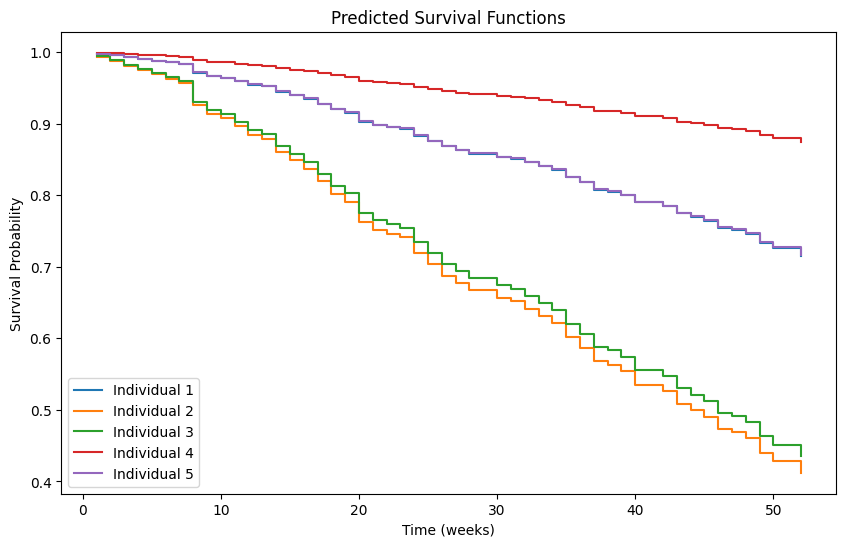

In [11]:
## optional

# Make predictions
# We can predict the survival function for each individual
# Here, we predict the survival function for the first 5 individuals
print("\nPredicted survival functions for the first 5 individuals:")
survival_functions = cox_model.predict_survival_function(data.iloc[:5])
print(survival_functions)

# Plot the survival functions
plt.figure(figsize=(10, 6))
for i in range(survival_functions.shape[1]):
    plt.step(survival_functions.index, survival_functions.iloc[:, i], where="post", label=f"Individual {i+1}")
plt.title("Predicted Survival Functions")
plt.xlabel("Time (weeks)")
plt.ylabel("Survival Probability")
plt.legend()
plt.show()

### split dataset for training models

In [12]:
## Split dataset randomly

num_model_pairs = 10
data_splits, memberships = split_dataframe_for_training(data, num_model_pairs)

### train cox models and get memberships and metadata

In [13]:
## Train cox models and get trained models and metadata

models, metadata = train_cox_models(
    data_splits=data_splits,
    num_model_pairs=num_model_pairs,
    log_dir="test_cox"
)

# Access the first model and its metadata
#print(metadata[0])  # Metadata for the first model
#models[0].print_summary()  # Summary of the first model

### prepare auditing dataset and memberships

In [14]:
## prepare auditing dataset and memberships

auditing_dataset, auditing_membership = sample_cox_auditing_dataset(data, memberships)

### compute signals

In [15]:
## compute signals (TODO: this is only pseudo LOSS signals!)
signals = get_cox_model_signals(models, auditing_dataset)

Signals saved to disk.


### perform model auditing

In [16]:
# Perform the privacy audit
num_experiments = num_model_pairs
target_model_indices = list(range(num_experiments))
mia_score_list, membership_list = audit_cox_models(
    target_model_indices,
    signals,
    auditing_membership,
)

Auditing the privacy risks of target model 0
Target Model 0: AUC 0.4814, 
Auditing the privacy risks of target model 1
Target Model 1: AUC 0.5246, 
Auditing the privacy risks of target model 2
Target Model 2: AUC 0.5066, 
Auditing the privacy risks of target model 3
Target Model 3: AUC 0.5042, 
Auditing the privacy risks of target model 4
Target Model 4: AUC 0.5065, 
Auditing the privacy risks of target model 5
Target Model 5: AUC 0.4970, 
Auditing the privacy risks of target model 6
Target Model 6: AUC 0.5130, 
Auditing the privacy risks of target model 7
Target Model 7: AUC 0.4938, 
Auditing the privacy risks of target model 8
Target Model 8: AUC 0.5110, 
Auditing the privacy risks of target model 9
Target Model 9: AUC 0.5019, 


<Figure size 640x480 with 0 Axes>